In [ ]:
!pip install pyspark

# Configuration PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Analyse des parcours universitaires et de la réussite en licence") \
    .getOrCreate()

# Chargement des données
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("delimiter", ";") \
    .load("/content/fr-esr-parcours-et-reussite-des-bacheliers-en-licence.csv")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7b3d117a34f5a3998c9c87a57d3592775af18130f813961499ef4d30316fa7d8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Nettoyage des données

In [ ]:
cleaned_data = df.dropna()

In [ ]:
#Vérifiez que Spark est correctement installé et configuré en exécutant une commande simple pour afficher la version de Spark :
spark.version


'3.5.1'

In [ ]:
df.show(5)


+-------------+--------------------+----------+--------------------+------------------+----------------------+---------+--------------------+----------+--------------------+----+--------+-----------+--------------------+---------------+------------------------------+------------------+------------------+-------------------+---------------------+-------------------------+--------------------------+--------------------+----------------+-------------------------------+--------------+--------------+----------------+
|gd_discipline|   gd_discipline_lib|discipline|      discipline_lib|sect_disciplinaire|sect_disciplinaire_lib|serie_bac|       serie_bac_lib|age_au_bac|      age_au_bac_lib|sexe|sexe_lib|mention_bac|     mention_bac_lib|cohorte_passage|effectif_neobacheliers_passage|passage_en_l2_1_an|redoublement_en_l1|passage_en_l2_2_ans|passage_en_l2_1_2_ans|reorientation_en_dut_1_an|reorientation_en_dut_2_ans|reorientation_en_dut|cohorte_reussite|effectif_neobacheliers_reussite|reussite_3_a

**Analyse des données et génération de graphiques**

Nous allons maintenant utiliser PySpark pour effectuer certaines analyses et Matplotlib pour les visualisations.

Importer les bibliothèques nécessaires


In [ ]:
# importer Matplotlib
import matplotlib.pyplot as plt


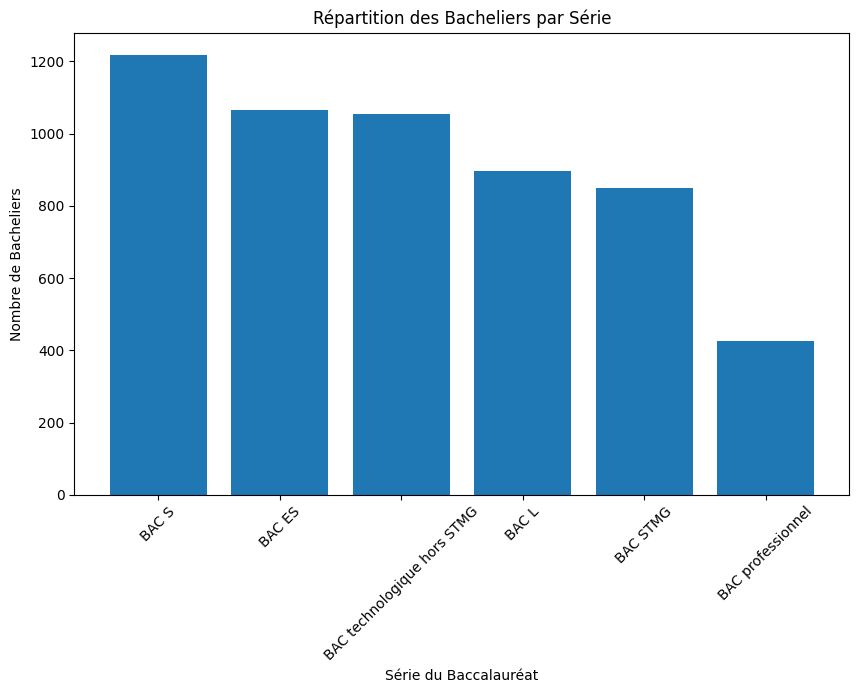

In [ ]:
#Répartition des bacheliers par série


# Compter le nombre de bacheliers par série
series_distribution = df.groupBy("serie_bac_lib").count().orderBy("count", ascending=False).toPandas()

# Visualiser la répartition avec un bar chart
plt.figure(figsize=(10, 6))
plt.bar(series_distribution['serie_bac_lib'], series_distribution['count'])
plt.xlabel('Série du Baccalauréat')
plt.ylabel('Nombre de Bacheliers')
plt.title('Répartition des Bacheliers par Série')
plt.xticks(rotation=45)
plt.show()

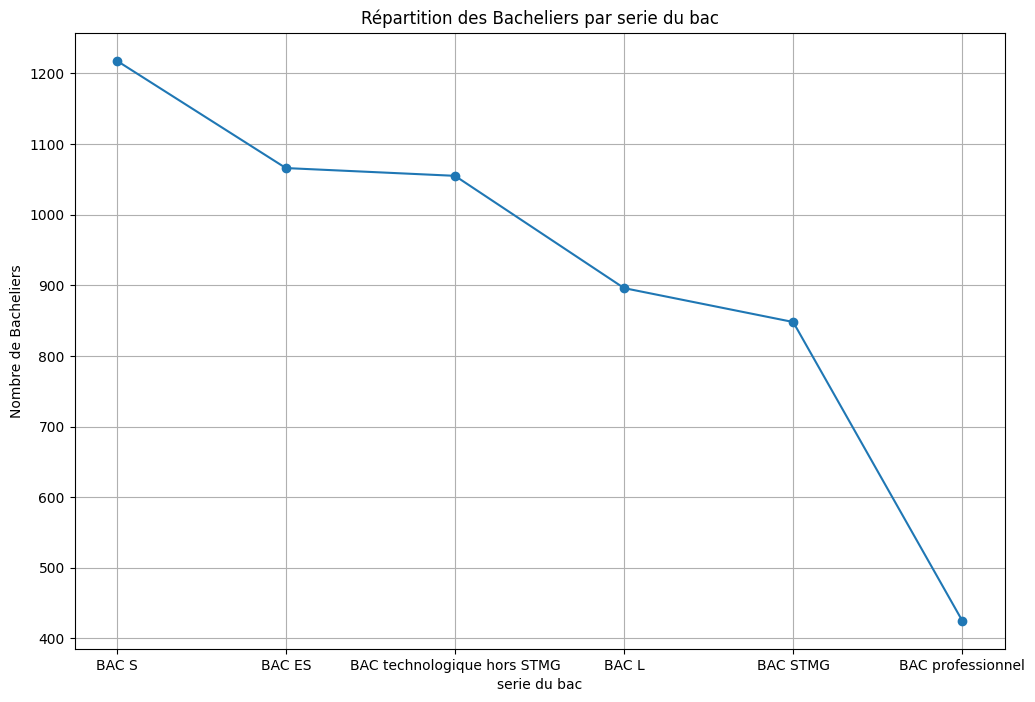

In [ ]:
# Compter le nombre de bacheliers par serie de bac
academie_distribution = df.groupBy("serie_bac_lib").count().orderBy("count", ascending=False).toPandas()

# Visualiser le taux de réussite avec une courbe
plt.figure(figsize=(12, 8))
plt.plot(academie_distribution['serie_bac_lib'], academie_distribution['count'], marker='o')
plt.xlabel('serie du bac')
plt.ylabel('Nombre de Bacheliers')
plt.title('Répartition des Bacheliers par serie du bac')
plt.grid(True)
plt.show()


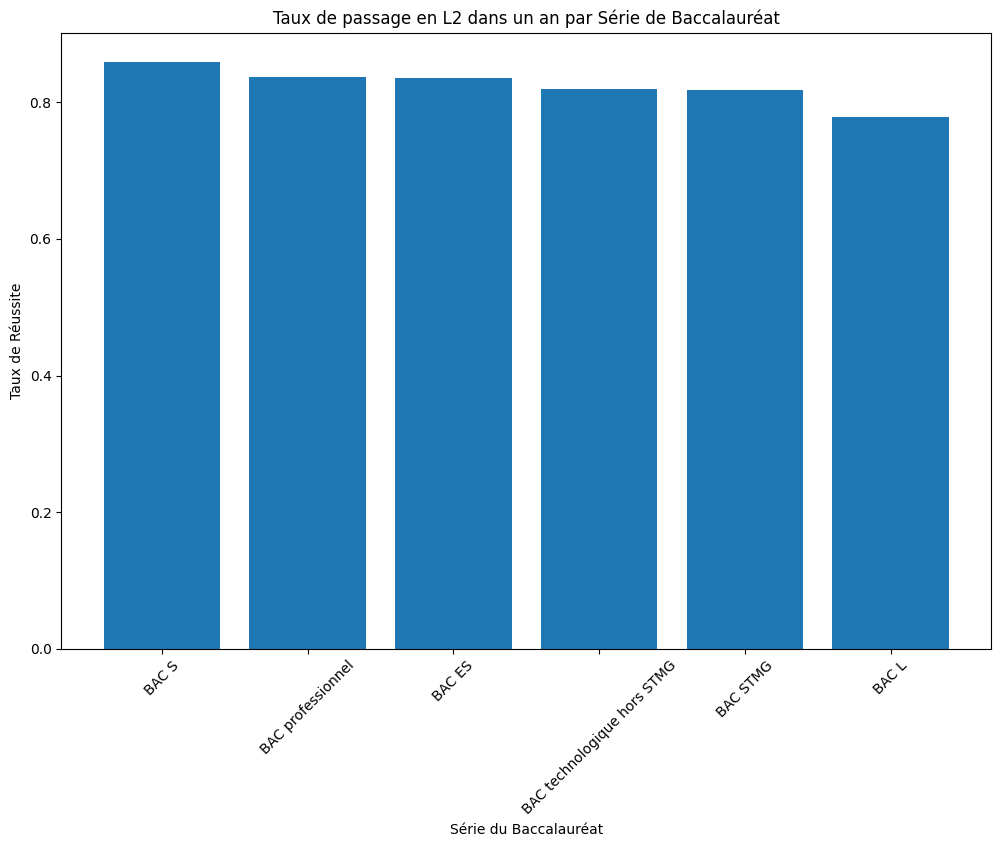

In [ ]:


# Ajouter une colonne indiquant si l'étudiant a réussi et convertir en type Integer
df = df.withColumn("Reussite", when(col("passage_en_l2_1_an").isNotNull(), 1).otherwise(0).cast(IntegerType()))

# Calculer le taux de réussite par série de baccalauréat
success_rate_by_series = df.groupBy("serie_bac_lib").agg(
    (sum("Reussite") / count("Reussite")).alias("Taux_de_reussite")
).orderBy("Taux_de_reussite", ascending=False).toPandas()

# Visualiser le taux de réussite avec un bar chart
plt.figure(figsize=(12, 8))
plt.bar(success_rate_by_series['serie_bac_lib'], success_rate_by_series['Taux_de_reussite'])
plt.xlabel('Série du Baccalauréat')
plt.ylabel('Taux de Réussite')
plt.title('Taux de passage en L2 dans un an par Série de Baccalauréat')
plt.xticks(rotation=45)
plt.show()

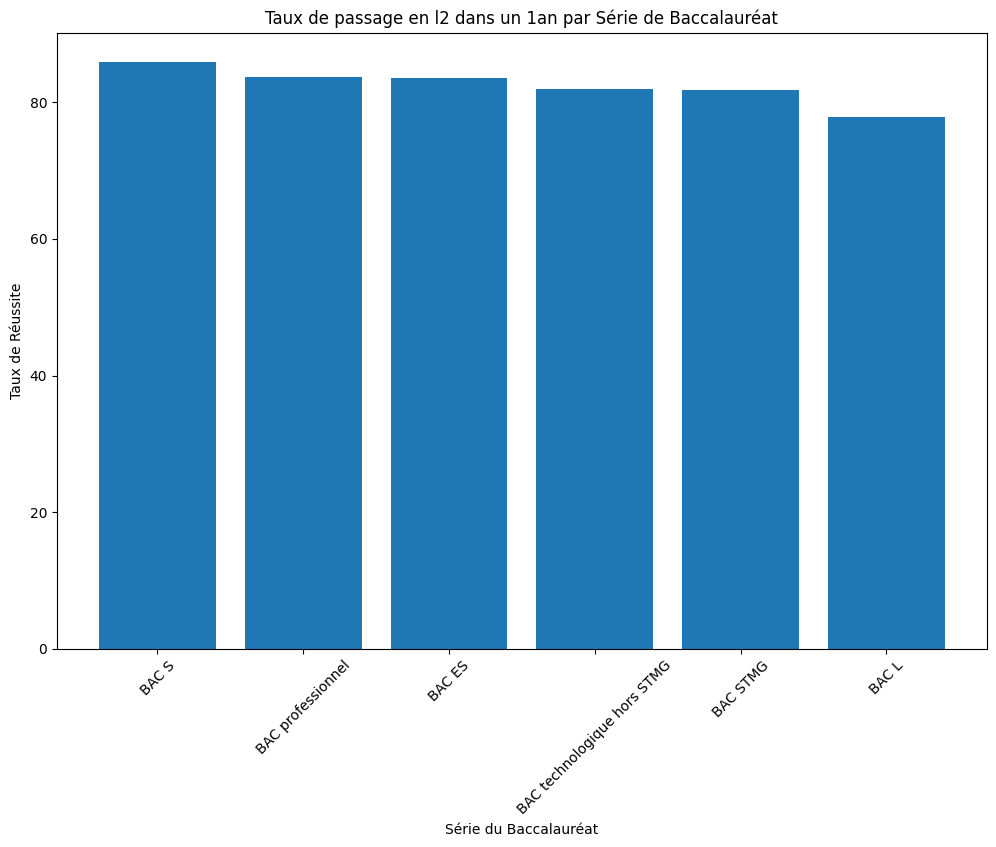

In [ ]:

#Taux de passage_en_l2 en 1 année par série de baccalauréat

from pyspark.sql.functions import when, col, sum, count
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when, col

# Ajouter une colonne indiquant si l'étudiant a réussi
df = df.withColumn("Reussite", when(col("passage_en_l2_1_an").isNotNull(), 1).otherwise(0))

# Calculer le taux de réussite par série de baccalauréat
success_rate_by_series = df.groupBy("serie_bac_lib").agg(
    (((sum("Reussite") / count("Reussite")))*100).alias("Taux_de_reussite")
).orderBy("Taux_de_reussite", ascending=False).toPandas()

# Visualiser le taux de réussite avec un bar chart
plt.figure(figsize=(12, 8))
plt.bar(success_rate_by_series['serie_bac_lib'], success_rate_by_series['Taux_de_reussite'])
plt.xlabel('Série du Baccalauréat')
plt.ylabel('Taux de Réussite')
plt.title('Taux de passage en l2 dans un 1an par Série de Baccalauréat')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Configuration PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une session Spark
spark = SparkSession.builder.appName("UniversityDataAnalysis").getOrCreate()


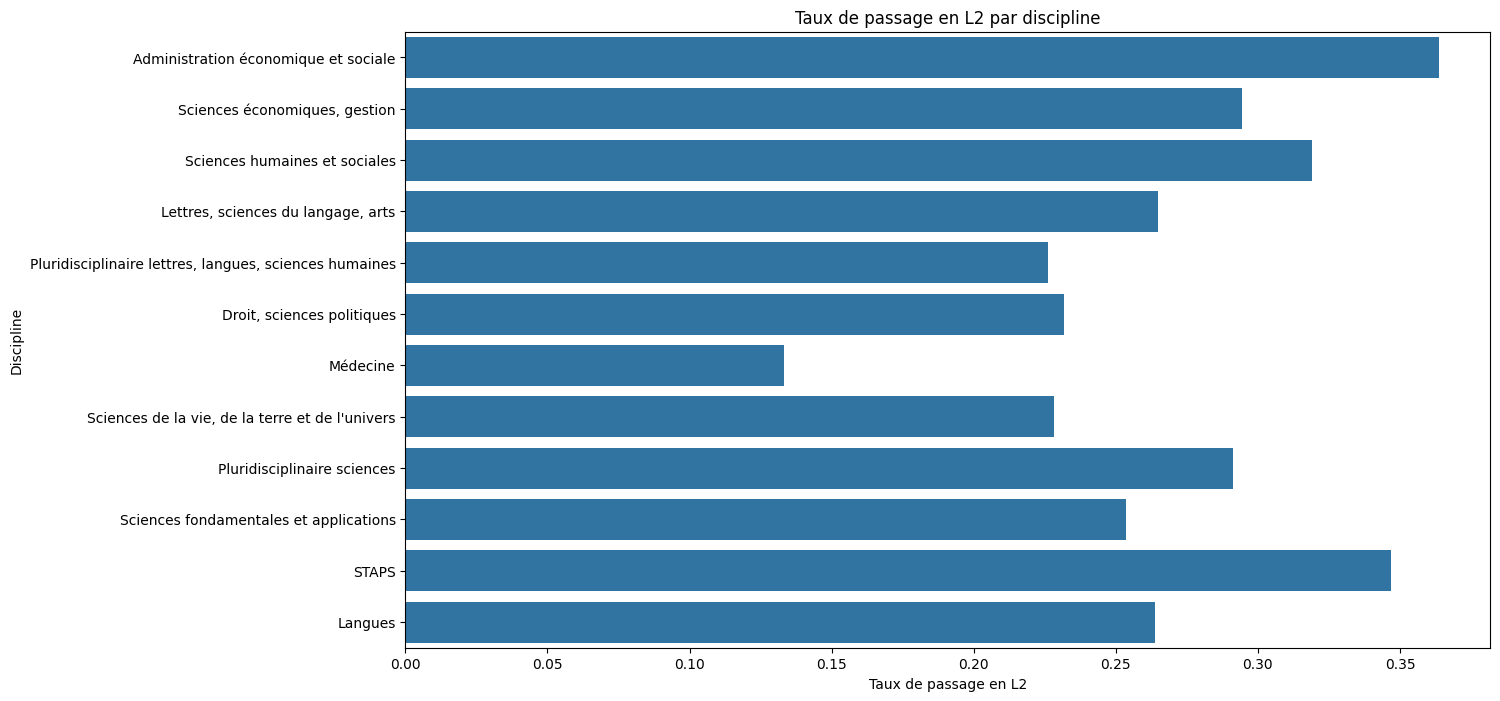

In [ ]:
"1. Taux de passage en L2 par Discipline "


# Créer une nouvelle colonne pour indiquer si un étudiant est passé en L2 en 1 ou 2 ans
df = df.withColumn("passage_en_l2", when(col("passage_en_l2_1_an") == 1, 1).otherwise(when(col("passage_en_l2_2_ans") == 1, 1).otherwise(0)))

# Calculer le taux de passage en L2 pour chaque discipline
passage_rates = df.groupBy("discipline_lib").agg((count(when(col("passage_en_l2") == 1, True)) / count("*")).alias("taux_de_passage_en_l2"))

# Convertir en DataFrame Pandas pour visualisation
passage_rates_pd = passage_rates.toPandas()

# Visualiser les taux de passage en L2 par discipline
plt.figure(figsize=(14, 8))
sns.barplot(x="taux_de_passage_en_l2", y="discipline_lib", data=passage_rates_pd)
plt.title("Taux de passage en L2 par discipline")
plt.xlabel("Taux de passage en L2")
plt.ylabel("Discipline")
plt.show()

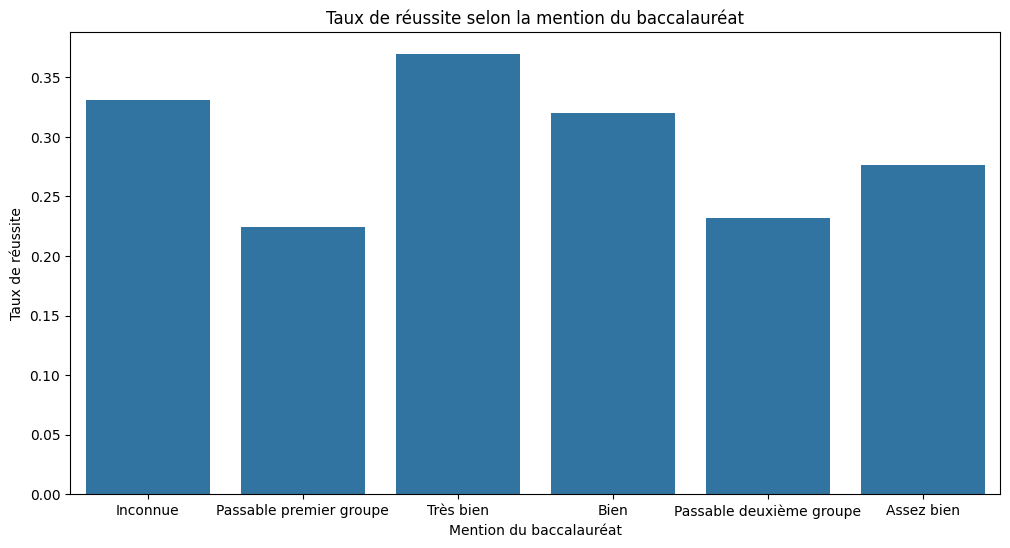

In [ ]:
"2. Impact de la mention du Bac sur les taux de réussite"


# Calculer les taux de réussite selon la mention du bac
mention_rates = df.groupBy("mention_bac_lib").agg((count(when(col("passage_en_l2") == 1, True)) / count("*")).alias("taux_de_reussite"))

# Convertir en DataFrame Pandas pour visualisation
mention_rates_pd = mention_rates.toPandas()

# Visualiser les taux de réussite par mention du bac
plt.figure(figsize=(12, 6))
sns.barplot(x="mention_bac_lib", y="taux_de_reussite", data=mention_rates_pd)
plt.title("Taux de réussite selon la mention du baccalauréat")
plt.xlabel("Mention du baccalauréat")
plt.ylabel("Taux de réussite")
plt.show()

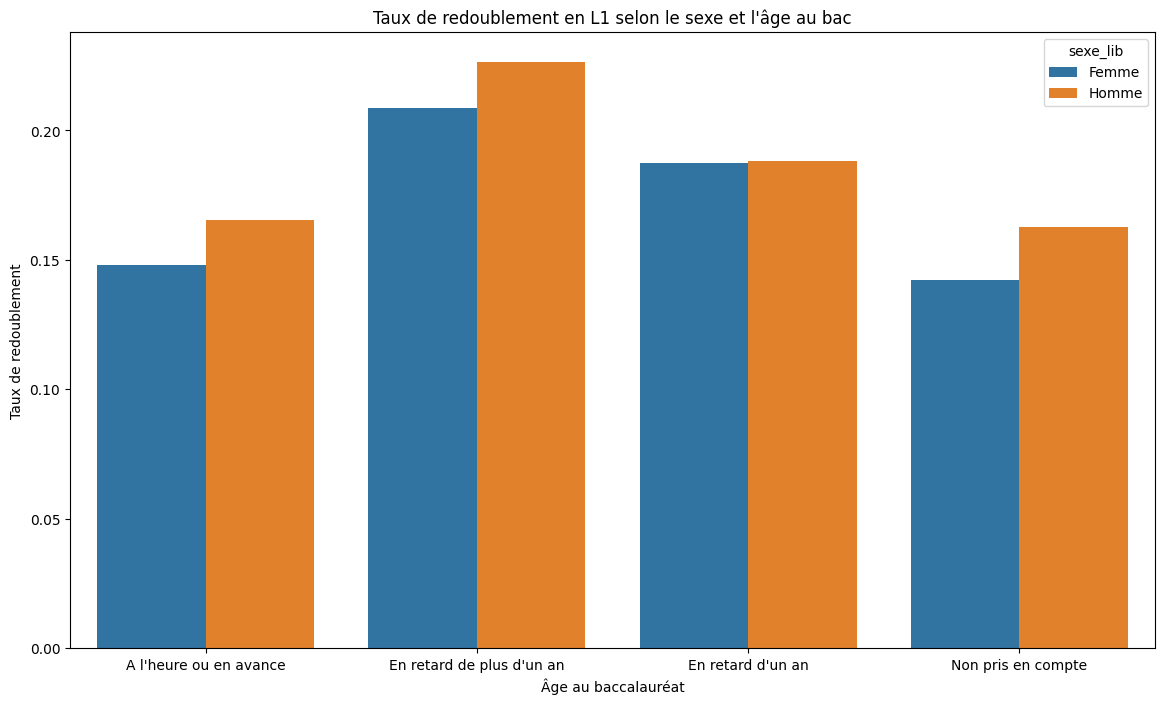

In [ ]:
"Tendance de redoublement en L1"

# Calculer les taux de redoublement selon le sexe et l'âge au bac
redoublement_rates = df.groupBy(
    "sexe_lib", "age_au_bac_lib").agg((count(when(col("redoublement_en_l1") == 1, True)) / count("*")).alias("taux_de_redoublement"))

# Convertir en DataFrame Pandas pour visualisation
redoublement_rates_pd = redoublement_rates.toPandas()

# Visualiser les taux de redoublement par sexe et âge au bac
plt.figure(figsize=(14, 8))
sns.barplot(x="age_au_bac_lib", y="taux_de_redoublement", hue="sexe_lib", data=redoublement_rates_pd)
plt.title("Taux de redoublement en L1 selon le sexe et l'âge au bac")
plt.xlabel("Âge au baccalauréat")
plt.ylabel("Taux de redoublement")
plt.show()

In [ ]:
"4. Tableau de bord interactif"

import plotly.express as px

# Exemple de graphique interactif pour les taux de passage en L2
fig = px.bar(passage_rates_pd, x="taux_de_passage_en_l2", y="discipline_lib", title="Taux de passage en L2 par discipline",
             labels={'taux_de_passage_en_l2':'Taux de passage en L2', 'discipline_lib':'Discipline'})
fig.show()